len(sha_001_df_drtn) : 4037, the total records number.
split_idx: 3229


len(hidden_states_seq_train) : 3229
len(hidden_states_seq_test) : 808

trained_hmm.transmat_:
[[ 0.32540406  0.00085628  0.11833957  0.0016753   0.51907867  0.03464613]
 [ 0.00424169  0.66530358  0.00801314  0.31408435  0.00349378  0.00486346]
 [ 0.31678032  0.00435722  0.11704084  0.00492495  0.52043083  0.03646584]
 [ 0.00071014  0.69878686  0.00111086  0.29814436  0.00075467  0.00049311]
 [ 0.33149098  0.00045685  0.12285666  0.00112747  0.50961573  0.03445231]
 [ 0.31580369  0.01661963  0.11437623  0.01577607  0.50429918  0.0331252 ]]

Means and vars of each hidden state
0th hidden state
mean =  [ 0.00015649]
var =  [ 0.00015549]

1th hidden state
mean =  [ 0.00289985]
var =  [ 0.00039841]

2th hidden state
mean =  [-0.00064483]
var =  [ 0.00031221]

3th hidden state
mean =  [-0.00570067]
var =  [ 0.00126538]

4th hidden state
mean =  [ 0.00029386]
var =  [ 0.00008838]

5th hidden state
mean =  [ 0.00039217]
var =  [ 0.00084098]



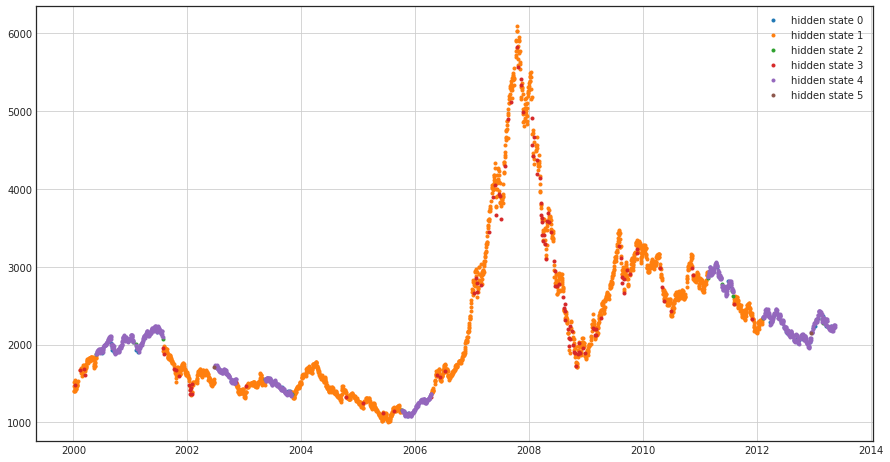

In [1]:
import numpy as np
from hmmlearn import hmm
import warnings
from sklearn import neighbors, preprocessing
import pandas as pd
import seaborn as sns
from analytic import utility
from analytic import ta_indicators

from matplotlib import cm
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# start cell 1
csv_files = ['SHA01']

# get raw, whole scale data
sha_001_df = utility.get_cols_from_csv_names(csv_files,
                                             interested_col=['Date', 'Close', 'Volume'],
                                             join_spy=False,
                                             base_dir='/home/boweiliu/workrepo/udacity_p_f/src/rawdata')
# reverse and select data required for study
sha_001_df = sha_001_df.iloc[::-1].loc['2000-01-04':'2016-09-02']

close = sha_001_df['SHA01_CLOSE']
volume = sha_001_df['SHA01_VOLUME']
date_list = pd.to_datetime(close.index)

original_rtn = ta_indicators.get_daily_return(sha_001_df['SHA01_CLOSE'])
ln_rtn = ta_indicators.get_ln_return(close)
ln_rtn.iloc[0] = 0.00001
print('len(sha_001_df_drtn) : {}, the total records number.'.format(len(ln_rtn)))
split_idx = int(len(ln_rtn) / 5.0 * 4.0)
print("split_idx: {}".format(split_idx))

drtn_nparray_train = np.array(ln_rtn.iloc[0: split_idx])
drtn_nparray_test = np.array(ln_rtn.iloc[split_idx:])

close_pds_train = close.iloc[0:split_idx]
close_pds_test = close.iloc[split_idx:]

volume_pds_train = volume.iloc[0:split_idx]
volume_pds_test = volume.iloc[split_idx:]

ln_rtn_pds_train = ln_rtn.iloc[0:split_idx]
ln_rtn_pds_test = ln_rtn.iloc[split_idx:]

date_list_train = date_list[0:split_idx]
date_list_test = date_list[split_idx:]

X = np.column_stack([drtn_nparray_train])
X_test = np.column_stack([drtn_nparray_test])

trained_hmm = hmm.GaussianHMM(n_components=6, covariance_type='diag', n_iter=50)
# only use sample section to train model
trained_hmm.fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states_seq_train = trained_hmm.predict(X)
h_s_seq_test = trained_hmm.predict(X_test)

print('len(hidden_states_seq_train) : {}'.format(len(hidden_states_seq_train)))
print('len(hidden_states_seq_test) : {}'.format(len(h_s_seq_test)))

print("\ntrained_hmm.transmat_:")
print(trained_hmm.transmat_)
print("\nMeans and vars of each hidden state")
for i in range(trained_hmm.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", trained_hmm.means_[i])
    print("var = ", np.diag(trained_hmm.covars_[i]))
    print()

sns.set_style('white')
plt.figure(figsize=(15, 8))
for i in range(trained_hmm.n_components):
    state = (hidden_states_seq_train == i)
    #  https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot
    plt.plot(date_list_train[state],  # x series
             close_pds_train.iloc[state],  # y series
             '.',  # point marker
             label='hidden state {}'.format(i),
             linewidth=1)
    plt.legend()
    plt.grid(1)
plt.show()


hidden_state_classification : 
 [1, 2, 1, 0, 1, 1]


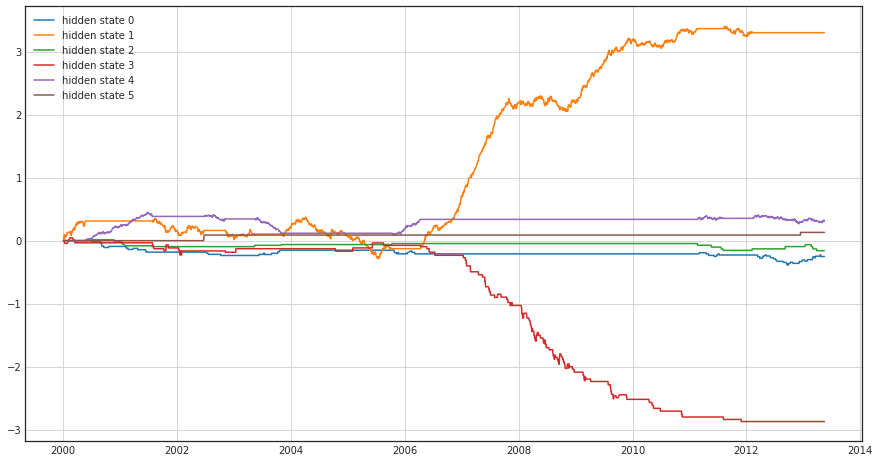

In [2]:
# start cell 2
h_s_class = []

plt.figure(figsize=(15, 8))
for state_i in range(trained_hmm.n_components):
    mask = [1 if state else 0 for state in (hidden_states_seq_train == state_i)]
    log_cum_rtn = ln_rtn_pds_train.multiply(mask, axis=0).cumsum()
    if log_cum_rtn.iloc[-1] > 0.5:
        # shang zhang hangqing
        h_s_class.append(2)
    elif log_cum_rtn.iloc[-1] < -0.5:
        # xia die hang qing
        h_s_class.append(0)
    else:
        # zheng dang hang qing
        h_s_class.append(1)
    plt.plot(log_cum_rtn, label='hidden state {}'.format(state_i))
    plt.legend()
    plt.grid(1)
print("hidden_state_classification : \n {}".format(h_s_class))
plt.show()

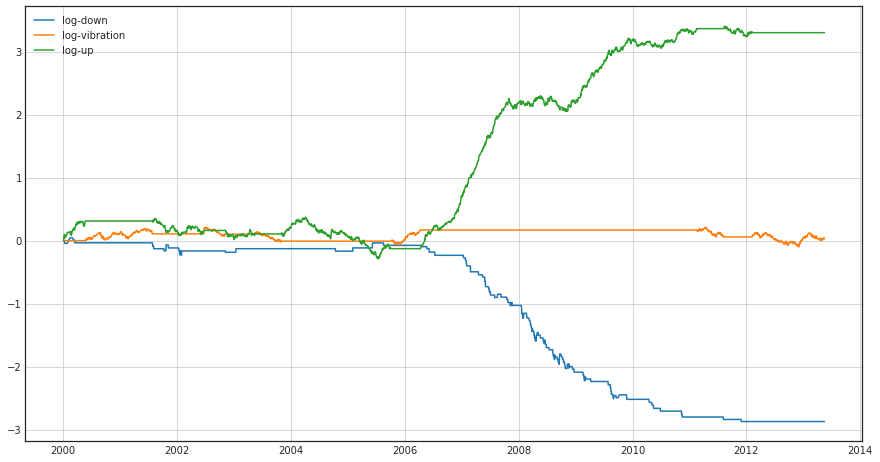

In [5]:
# start cell 3
# remapping hidden states sequence into assumed states sequence
assumed_states_seq_train = np.array(
    [h_s_class[hidden_state_i]
     for hidden_state_i in hidden_states_seq_train])
# 0 means xia die
# 1 means zhengdang
# 2 means shangzhang
# print(assumed_states_seq_train == 2)

plt.figure(figsize=(15, 8))
for state_i in range(3):
    mask = [1 if assume_state == state_i else 0 for assume_state in assumed_states_seq_train]
    assumed_states_rtn = ln_rtn_pds_train.multiply(mask, axis=0)
    assumed_states_cum_rtn = assumed_states_rtn.cumsum()
    the_label = 'log-up' if state_i == 2 else 'log-down' if state_i == 0 else 'log-vibration'
    plt.plot(assumed_states_cum_rtn, label=the_label)
    plt.legend()
    plt.grid(1)
plt.show()

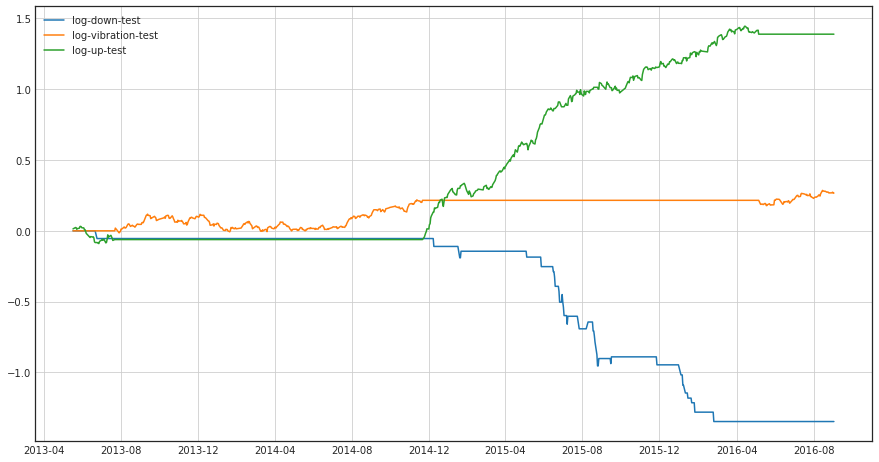

In [6]:

# start cell 4
# remapping hidden states sequence into assumed states sequence
assumed_states_seq_test = np.array([h_s_class[hsi] for hsi in h_s_seq_test])
# 0 means xia die
# 1 means zhengdang
# 2 means shangzhang
# print(assumed_states_seq_train == 2)

plt.figure(figsize=(15, 8))
for state_i in range(3):
    mask = [1 if assume_state == state_i else 0 for assume_state in assumed_states_seq_test]
    assumed_states_rtn_test = ln_rtn_pds_test.multiply(mask, axis=0)
    assumed_states_cum_rtn_test = assumed_states_rtn_test.cumsum()
    the_label = 'log-up-test' if state_i == 2 else \
        'log-down-test' if state_i == 0 else 'log-vibration-test'
    plt.plot(assumed_states_cum_rtn_test, label=the_label)
    plt.legend()
    plt.grid(1)
plt.show()
